In [317]:
import logging
import os
import pickle
import time
import statistics
from abc import abstractmethod

import colorsys
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import hdbscan

from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score


<font size = 5>Load Data, Create airspeedchange feature and Drop other rows</font>

In [318]:
f0 = 'base.csv'
f1 = 'random1.csv'
f2 = 'wind1.csv'
f3 = 'engine1.csv'
f4 = 'sensor1.csv'
f5 = 'crash.csv'

base_df = pd.read_csv(f0, header=0, index_col=None)
random1_df = pd.read_csv(f1, header=0, index_col=None)
wind1_df = pd.read_csv(f2, header=0, index_col=None)
engine1_df = pd.read_csv(f3, header=0, index_col=None)
sensor1_df = pd.read_csv(f4, header=0, index_col=None)
crash1_df = pd.read_csv(f5, header=0, index_col=None)

df_list = [base_df, random1_df, wind1_df, engine1_df, sensor1_df,crash1_df]

for df in df_list:

    df['airspeedchange'] = df['airspeed']- df['airspeed'].shift(1)
    df['airspeedchange'].fillna(0, inplace=True)

base_df = base_df[['roll', 'pitch', 'yaw', 'rollspeed', 'pitchspeed', 'yawspeed',  'airspeedchange']]
random1_df = random1_df[['roll', 'pitch', 'yaw', 'rollspeed', 'pitchspeed', 'yawspeed', 'airspeedchange']]
wind1_df = wind1_df[['roll', 'pitch', 'yaw', 'rollspeed', 'pitchspeed', 'yawspeed', 'airspeedchange']]
engine1_df = engine1_df[['roll', 'pitch', 'yaw', 'rollspeed', 'pitchspeed', 'yawspeed', 'airspeedchange']]
sensor1_df = sensor1_df[['roll', 'pitch', 'yaw', 'rollspeed', 'pitchspeed', 'yawspeed', 'airspeedchange']]
crash1_df = crash1_df[['roll', 'pitch', 'yaw', 'rollspeed', 'pitchspeed', 'yawspeed', 'airspeedchange']]



<font size = 5> Count Anomalies </font>

In [319]:
random1_nonanomalies = len(random1_df)
wind1_anomalies = len(wind1_df)
engine1_anomalies = len(engine1_df)
sensor1_anomalies = len(sensor1_df)
crash1_anomalies = len(crash1_df)


<font size = 5> Train DBScan Model with Base Data</font>

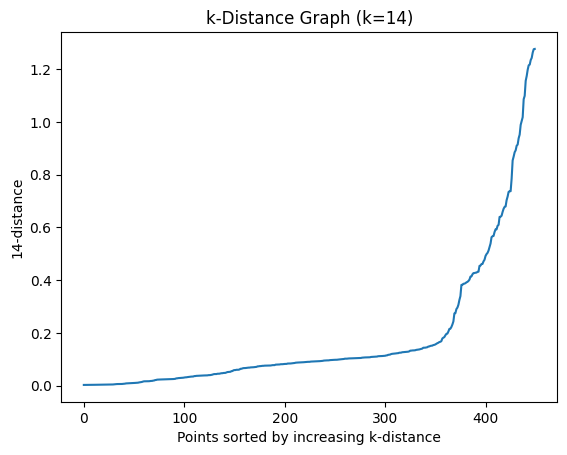

In [320]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Compute the k-distance graph
k = 14  # Choose a value of k
nbrs = NearestNeighbors(n_neighbors=k+1).fit(base_df)
distances, indices = nbrs.kneighbors(base_df)
k_distances = np.mean(distances[:, 1:], axis=1)  # Compute the average k-distance

# Plot the k-distance graph
k_distances_sorted = np.sort(k_distances)
plt.plot(np.arange(len(base_df)), k_distances_sorted)
plt.xlabel("Points sorted by increasing k-distance")
plt.ylabel(f"{k}-distance")
plt.title(f"k-Distance Graph (k={k})")
plt.show()

In [321]:
#hyperparameter tuning

eps = np.arange(0.2, 0.8, 0.01)
output = []

for ep in eps:
        labels = DBSCAN(min_samples = 14, eps = ep).fit(base_df).labels_
        score = silhouette_score(base_df, labels)
        output.append((ep, score))

eps, score = sorted(output, key=lambda x:x[-1])[-1]
print(f"Best silhouette_score: {score}")
print(f"eps: {eps}")

Best silhouette_score: 0.6942980872461431
eps: 0.7800000000000005


In [322]:
db = DBSCAN(eps = 0.78).fit(base_df)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

pd.set_option('display.max_rows', None)

df_copy = base_df.copy()
df_copy['labels'] = labels
df_copy[df_copy['labels'] == -1]


Estimated number of clusters: 3
Estimated number of noise points: 9


,roll,pitch,yaw,rollspeed,pitchspeed,yawspeed,airspeedchange,labels
110,-0.102548,-0.005580,-0.635784,-0.097652,-0.002467,-0.832092,0.693333,-1
111,-0.109000,-0.083279,-1.224027,-0.095855,-0.028607,-0.748366,0.590000,-1
129,0.123062,0.119966,-2.046377,-0.466843,0.025571,0.416250,-1.138333,-1
130,0.199590,-0.031008,-1.184911,-0.049511,-0.008598,0.724867,-0.283000,-1
131,0.174776,-0.136949,-0.661799,-0.014001,0.000693,0.706794,1.114667,-1
156,0.079339,0.043601,0.023239,0.577598,0.006169,0.018202,-1.316667,-1
159,0.165747,-0.079007,0.847219,0.251936,-0.036988,0.621744,-0.044333,-1
187,0.180530,-0.019618,2.361667,0.040535,-0.020511,0.786343,-0.189000,-1
188,0.105574,-0.173607,-1.005884,0.008460,0.010727,0.392719,1.149333,-1


In [323]:
#export to csv to view clusters for sense-making
df_copy.to_csv('dbscantraining.csv')

In [324]:
# get cluster counts
s = df_copy['labels']
s.value_counts()

 1    278
 0    136
 2     27
-1      9
Name: labels, dtype: int64

In [325]:
#get clusters
clusters = s.unique()
clusters

array([ 0, -1,  1,  2])

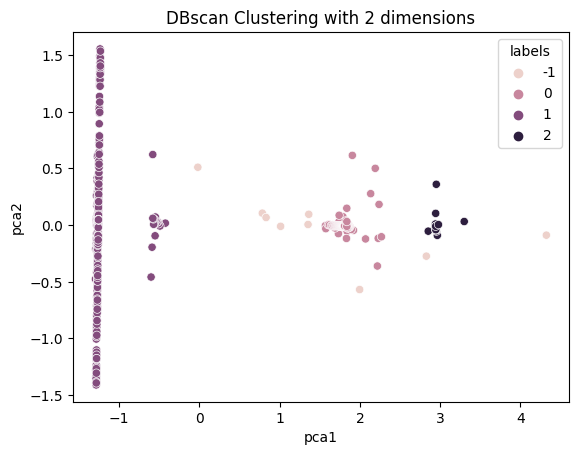

In [326]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(df_copy)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=df_copy['labels'], data=results)
plt.title('DBscan Clustering with 2 dimensions')
plt.show()

<font size = 5>Predicting using random missions (RQ1)</font>

In [327]:
#predict new points
new_labels = db.fit_predict(random1_df)

#save into new df as we want to preserve original df
random1_df2 = random1_df.copy()
random1_df2["cluster"] = new_labels

random1_df2["cluster"].value_counts()

 1    186
 0    159
-1      9
Name: cluster, dtype: int64

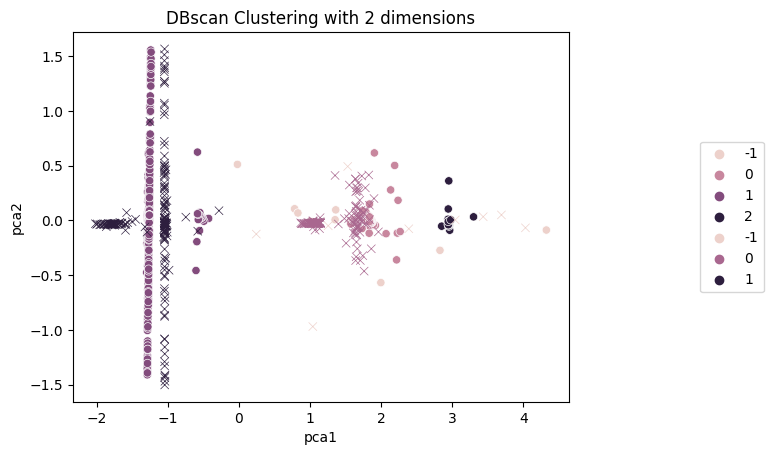

In [328]:
#plot against original
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(df_copy)
test_reduced_data = PCA(n_components=pca_num_components).fit_transform(random1_df2)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
test_results = pd.DataFrame(test_reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=df_copy['labels'], data=results)
sns.scatterplot(x="pca1", y="pca2", hue = random1_df2['cluster'], marker = "x", data=test_results)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('DBscan Clustering with 2 dimensions')
plt.show()

<font size = 5> Finding number of nonanomalies for random missions </font>

In [329]:
count = 0

for i in range(len(random1_df2)):
    if int(random1_df2.iloc[i]['cluster']) == -1:
        count += 1
    elif int(random1_df2.iloc[i]['cluster']) not in clusters:
        count += 1

nonanomalies = random1_nonanomalies - count
nonanomaly_percentage = nonanomalies/random1_nonanomalies*100

print(nonanomalies, "of the observations are nonanomalies, which is equal to", nonanomaly_percentage,"%")

345 of the observations are nonanomalies, which is equal to 97.45762711864407 %


<font size = 5> Predicting using Wind Proxy (RQ2 1/4) </font>

In [330]:
#predict new points
new_labels = db.fit_predict(wind1_df)

#save into new df as we want to preserve original df
wind1_df2 = wind1_df.copy()
wind1_df2["cluster"] = new_labels

wind1_df2["cluster"].value_counts()

 1    548
 0     85
-1     21
 2     20
Name: cluster, dtype: int64

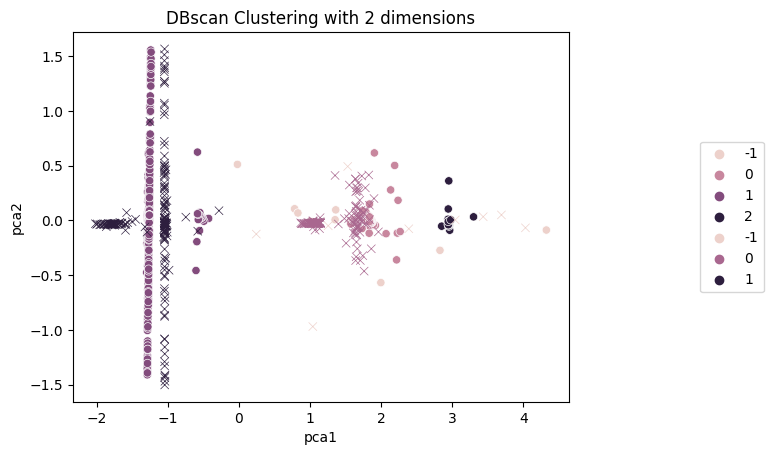

In [331]:
#plot against original
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(df_copy)
test_reduced_data = PCA(n_components=pca_num_components).fit_transform(random1_df2)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
test_results = pd.DataFrame(test_reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=df_copy['labels'], data=results)
sns.scatterplot(x="pca1", y="pca2", hue = random1_df2['cluster'], marker = "x", data=test_results)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('DBscan Clustering with 2 dimensions')
plt.show()

<font size = 5> Finding number of outliers for wind proxy </font>

In [332]:
count = 0

for i in range(len(wind1_df2)):
    if int(wind1_df2.iloc[i]['cluster']) == -1:
        count += 1
    elif int(wind1_df2.iloc[i]['cluster']) not in clusters:
        count += 1

anomaly_percentage = count/wind1_anomalies*100

print(count, "of the observations are anomalies, which is equal to", anomaly_percentage,"%")

21 of the observations are anomalies, which is equal to 3.115727002967359 %


<font size = 5> Predicting using Engine Fault (RQ2 2/3) </font>

In [333]:
#predict new points
new_labels = db.fit_predict(engine1_df)

#save into new df as we want to preserve original df
engine1_df2 = engine1_df.copy()
engine1_df2["cluster"] = new_labels

engine1_df2["cluster"].value_counts()

 0    419
 1     47
-1      4
Name: cluster, dtype: int64

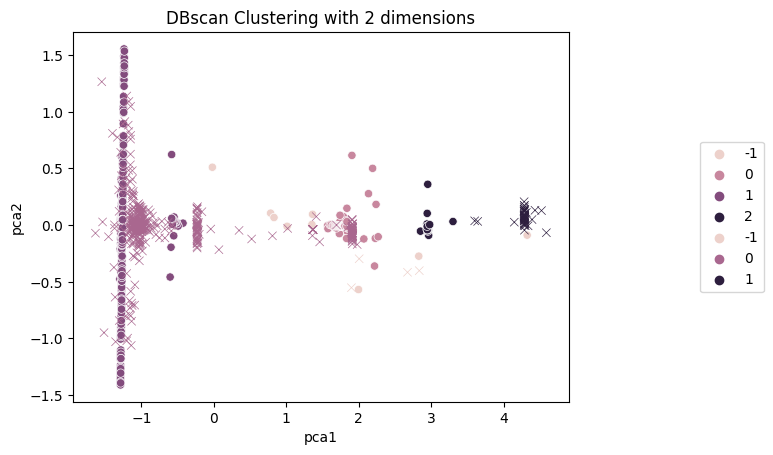

In [334]:
#plot against original
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(df_copy)
test_reduced_data = PCA(n_components=pca_num_components).fit_transform(engine1_df2)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
test_results = pd.DataFrame(test_reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=df_copy['labels'], data=results)
sns.scatterplot(x="pca1", y="pca2", hue = engine1_df2['cluster'], marker = "x", data=test_results)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('DBscan Clustering with 2 dimensions')
plt.show()

<font size = 5> Finding number of outliers for engine fault </font>

In [335]:
count = 0

for i in range(len(engine1_df2)):
    if int(engine1_df2.iloc[i]['cluster']) == -1:
        count += 1
    elif int(engine1_df2.iloc[i]['cluster']) not in clusters:
        count += 1

anomaly_percentage = count/engine1_anomalies*100

print(count, "of the observations are anomalies, which is equal to", anomaly_percentage,"%")

4 of the observations are anomalies, which is equal to 0.851063829787234 %


<font size = 5> Predicting using Sensor Fault (RQ2 3/3) </font>

In [336]:
#predict new points
new_labels = db.fit_predict(sensor1_df)

#save into new df as we want to preserve original df
sensor1_df2 = sensor1_df.copy()
sensor1_df2["cluster"] = new_labels

sensor1_df2["cluster"].value_counts()

 0    183
 2     13
 1     10
-1      6
Name: cluster, dtype: int64

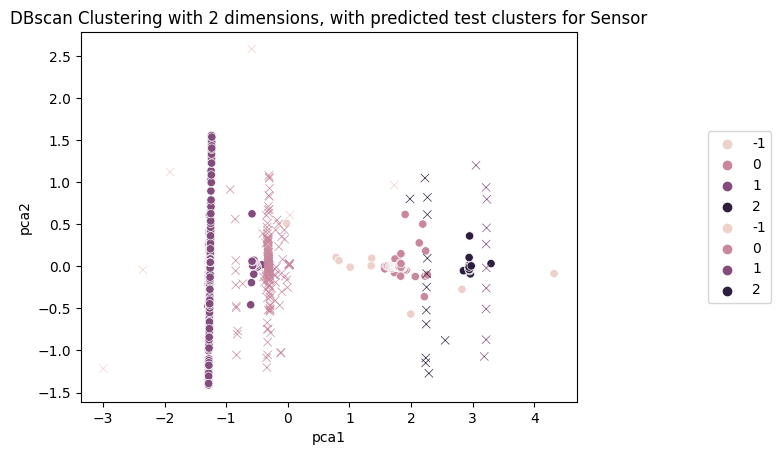

In [341]:
#plot against original
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(df_copy)
test_reduced_data = PCA(n_components=pca_num_components).fit_transform(sensor1_df2)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
test_results = pd.DataFrame(test_reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=df_copy['labels'], data=results)
sns.scatterplot(x="pca1", y="pca2", hue = sensor1_df2['cluster'], marker = "x", data=test_results)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('DBscan Clustering with 2 dimensions, with predicted test clusters for Sensor')
plt.show()

In [338]:
count = 0

for i in range(len(sensor1_df2)):
    if int(sensor1_df2.iloc[i]['cluster']) == -1:
        count += 1
    elif int(sensor1_df2.iloc[i]['cluster']) not in clusters:
        count += 1

anomaly_percentage = count/sensor1_anomalies*100

print(count, "of the observations are anomalies, which is equal to", anomaly_percentage,"%")

6 of the observations are anomalies, which is equal to 2.8301886792452833 %


<font size = 5> Predicting using Crash (RQ2 4/4) </font>

In [339]:
#predict new points
new_labels = db.fit_predict(crash1_df)

#save into new df as we want to preserve original df
crash1_df2 = crash1_df.copy()
crash1_df2["cluster"] = new_labels

crash1_df2["cluster"].value_counts()

 0    50
-1    15
 1     9
Name: cluster, dtype: int64

In [340]:
count = 0

for i in range(len(crash1_df2)):
    if int(crash1_df2.iloc[i]['cluster']) == -1:
        count += 1
    elif int(crash1_df2.iloc[i]['cluster']) not in clusters:
        count += 1

anomaly_percentage = count/crash1_anomalies*100

print(count, "of the observations are anomalies, which is equal to", anomaly_percentage,"%")

15 of the observations are anomalies, which is equal to 20.27027027027027 %
